In [1]:
##### prepare 10k IMMU tables 
# Step 1: investigate single studies for data collection platforms
# Step 2: Describe “formatted” preprocessing way as i can find in literature -> for Microarray its rather clear, right ?
# Step 3: Standartize them to make them comparable
# Step 4: Add 3-4 paper´s data to also get a deseased dataset (or maybe even finish the search in immport, as I think new studies got collected since release of 10kimmu)
# Step 5: GAMLLS model creation. 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import sys
sys.path.append('/home/eliasschreiner/PROJEKT/utils/')  # Adjust this to the path where `utils` resides

from utils.helper import manhattanplot, violinplot_overall, scatter_plot, get_negative_values, METADATA_COLS


In [2]:

ten_k_prefix="/var/datasets/10kImmunomes/transcriptomics/"
### Files we got:
## pbmc_rna_counts.csv
## whole_blood_rna_tpm.csv
## Gene_Expression_PBMC 
### gene_pbmc_formatted.csv ; gene_pbmc_normalized.csv  -> i take formatted as the wholeblood only exists in formatted... 
## Gene_Expression_Whole_Blood_formatted.csv 

print("\n###########################################################")
print("rna_seq_whole_blood.csv")
print("============================================================")
rna_seq_whole_blood = pd.read_csv(f"{ten_k_prefix}/whole_blood_rna_tpm.csv",sep=",")
print(rna_seq_whole_blood.columns)
print(rna_seq_whole_blood.shape)

print("\n###########################################################")
print("marray_whole_blood")
print("============================================================")
marray_whole_blood = pd.read_csv(f"{ten_k_prefix}/Gene_Expression_Whole_Blood_formatted.csv",sep=",")
print(marray_whole_blood.columns)
print(marray_whole_blood.shape)



###########################################################
rna_seq_whole_blood.csv
Index(['ensembl', 'hgnc', 'P14_D0', 'P14_D3', 'P17_D0', 'P17_D7', 'P21_D0',
       'P21_D3', 'P23_D0', 'P23_D7',
       ...
       'X50_L6.LB12', 'X100_L4.LB2', 'X31_L4.LB9', 'X64_P_L4.LB13',
       'X67_L1.LB15', 'X107_L5.LB3', 'X19_L3.LB5', 'X39_L1.LB10',
       'X96_L5.LB23', 'X81_L7.LB16'],
      dtype='object', length=355)
(9587, 355)

###########################################################
marray_whole_blood
Index(['data_accession', 'subject_accession', 'age', 'gender', 'race',
       'study_accession', 'EEF1A1', 'GAPDH', 'SLC35E2', 'DUSP22',
       ...
       'CTXN2', 'KRTAP20-3', 'SNHG8', 'NA.221', 'PSORS1C3', 'PISRT1', 'NA.222',
       'NA.223', 'KRTAP22-2', 'KRTAP21-3'],
      dtype='object', length=18424)
(464, 18424)


# Microarray

In [3]:
####Microarray Data: Gene expression array data were obtained in three formats.
# Data in their original formats (.CEL files, series matrix files, etc) constitute the “raw” gene expression data.

# For data collected on Affymetrix platforms, we utilized the ReadAffy utility in the affy Bioconductor package to read in raw .CEL files. 
# The rma utility was used to conduct Robust Multichip Average (rma) background correction (as in (4)), quantile normalization, and log2 normalization of the data. 
##### CRITERIA: PLATFORM_DESCRIPTION contains 'Affymetrix'

# For data collected on Illumina platforms and stored in the Gene Expression Omnibus (GEO) database, we utilized the getGEO utility in the 
# GEOquery Bioconductor package to read the expression files and the preprocessCore package to conduction rma background correction, quantile normalization, and log2 normalization of the gene expression data.
##### CRITERIA: PLATFORM_DESCRIPTION contains 'illumina'

# Finally, for data collected on Illumina platforms but not stored in GEO, we utilized the read.ilmn utility of the limma Bioconductor package 
# to read in the data, and the neqc function to rma background correct, quantile normalize, and log2 normalize the gene expression data.
##### CRITERIA: Study has GSMxxxxxxxx information for study ? 

# In all instances, probe IDs were converted to Entrez Gene IDs. Where multiple probes mapped to the same Entrez Gene ID, 
# the median value across probes was used to represent the expression value of the corresponding gene.
# The background-corrected and normalized datasets were combined based on common Entrez IDs, missing values were imputed with a 
# k-nearest neighbors algorithm (R package: impute, function: impute.knn) using k = 10 and default values for rowmax, colmax, and maxp. 
# Enter Gene IDs were then converted to HUGO gene names. 
# These steps together produced the “formatted” gene expression files.

# To create the “formatted and normalized” datasets, we utilized established empirical Bayes algorithm ComBat for batch correction (2), compensating for possible batch effects while maintaining potential effects of age, race, and sex across datasets.


In [4]:

#### Procedure of getting the platform: 
#### Try to get the Repo_Accessions (gene_expression table) for the study.
######## If found, output all platforms for the accessions. (was always only 1)
######## If not found, download the protocols from ImmPort via study acession -> read the microarray protocol and try to find the geo id (succeeded in all but SDY364) 
# needed: immport_platform.ipynb
marray_whole_blood = pd.read_csv(f"{ten_k_prefix}/Gene_Expression_Whole_Blood_formatted.csv",sep=",")
mapping_platform_geo_id = {'SDY111': 'GPL10558', 'SDY112': 'GPL15207', 
                    'SDY113': 'GPL15207', 'SDY144': 'GPL10558',
                    'SDY180': 'GPL6947', 'SDY212': 'GPL6947',
                    'SDY301': 'GPL6947', 'SDY305': 'GPL15207',
                    'SDY364': '?', 'SDY690': 'GPL6947',
                    }	
mapping_platform_description = {'SDY111': 'Illumina HumanHT-12 V4.0 expression beadchip', 'SDY112': '[PrimeView] Affymetrix Human Gene Expression Array', 
                    'SDY113': '[PrimeView] Affymetrix Human Gene Expression Array', 'SDY144': 'Illumina HumanHT-12 V4.0 expression beadchip',
                    'SDY180': 'Illumina HumanHT-12 V3.0 expression beadchip', 'SDY212': 'Illumina HumanHT-12 V3.0 expression beadchip',
                    'SDY301': 'Illumina HumanHT-12 V3.0 expression beadchip', 'SDY305': '[PrimeView] Affymetrix Human Gene Expression Array',
                    'SDY364': 'Illumina Human WG-6 V4 beadchips', 'SDY690': 'Illumina HumanHT-12 V3.0 expression beadchip',
                    }
marray_whole_blood['PLATFORM_GEO_ID'] = marray_whole_blood['study_accession'].apply(lambda x: mapping_platform_geo_id.get(x))
marray_whole_blood['PLATFORM_DESCRIPTION'] = marray_whole_blood['study_accession'].apply(lambda x: mapping_platform_description.get(x))


### For SDY112: data_Accession = Ji_Batch2_22.295185 ...   -> download protocols hat geholfen
### SDY301 -> ES769620 aber finde nicht im expsample ...  -> nicht in gene_expression ABER in expsample 
###### in EXPSAMPLE table: Upload_status -> Not parsed. also ich denke es ist irgendwas kaputt gegangen, es hat auch nur einen eintrag .  aus Experiment id: 'AIRFV Microarray'  -> download protocols hat geholfen
### SDY690 -> ES769464 ... same story...  wieso sind die nicht im gene expression enthalten ? 
###### Exp name: 'Compare whole blood (Tempus tube) to PBMC gene...	' -> download protocols hat geholfen
### SDY364 -> 8962917052_E ?????? wat  -> download protocols hat geholfen 
###### Leider hab ich die GEO accession nicht komplett wiedergefunden und hab mal GPL14951 eingetragen

## Rearrange columns: 
cols = marray_whole_blood.columns.tolist()
cols = cols[-2:] + cols[:-2]
marray_whole_blood = marray_whole_blood[cols]

print(marray_whole_blood['study_accession'].unique()) 
marray_whole_blood = marray_whole_blood.dropna()
marray_whole_blood.to_csv(f'whole_blood/microarray_whole_blood/marray_whole_blood_prepared.csv')

print(f'Studies: {marray_whole_blood.shape}')
print(f'Studies: {len(marray_whole_blood['study_accession'].unique())}')
print(f'Subjects: {len(marray_whole_blood['subject_accession'].unique())}')
print(f'Data ACCESSIONS ??: {len(marray_whole_blood['data_accession'].unique())}')
marray_whole_blood.head()


['SDY111' 'SDY112' 'SDY113' 'SDY144' 'SDY180' 'SDY212' 'SDY301' 'SDY305'
 'SDY364' 'SDY690']
Studies: (464, 18426)
Studies: 10
Subjects: 311
Data ACCESSIONS ??: 464


,PLATFORM_GEO_ID,PLATFORM_DESCRIPTION,data_accession,subject_accession,age,gender,race,study_accession,EEF1A1,GAPDH,...,CTXN2,KRTAP20-3,SNHG8,NA.221,PSORS1C3,PISRT1,NA.222,NA.223,KRTAP22-2,KRTAP21-3
0,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300358,SUB116437,63.9,Male,White,SDY111,12.900495,10.160145,...,6.470868,6.567214,7.014136,6.576544,6.544904,6.611353,6.458018,6.504691,6.435031,6.456866
1,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300366,SUB116437,63.9,Male,White,SDY111,12.900495,10.160145,...,6.470868,6.567214,7.014136,6.576544,6.544904,6.611353,6.458018,6.504691,6.435031,6.456866
2,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300371,SUB116438,64.2,Female,White,SDY111,12.525918,10.023569,...,6.565738,6.567646,6.999655,6.509168,6.596500,6.608629,6.451947,6.557095,6.561815,6.440005
3,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300363,SUB116438,64.2,Female,White,SDY111,12.525918,10.023569,...,6.565738,6.567646,6.999655,6.509168,6.596500,6.608629,6.451947,6.557095,6.561815,6.440005
4,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300374,SUB116439,68.9,Female,White,SDY111,12.936886,10.050780,...,6.565028,6.618523,6.777988,6.607149,6.484453,6.569432,6.656809,6.498053,6.502213,6.524032


In [5]:
marray_whole_blood.describe()

,age,EEF1A1,GAPDH,SLC35E2,DUSP22,RPS28,IPO13,AFAP1,CDT1,TRPV1,...,CTXN2,KRTAP20-3,SNHG8,NA.221,PSORS1C3,PISRT1,NA.222,NA.223,KRTAP22-2,KRTAP21-3
count,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,...,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000
mean,42.342155,12.429554,11.149355,5.262025,7.540902,11.832506,5.378389,4.722360,3.892076,3.558997,...,3.798582,4.235707,6.257251,3.593895,3.773600,4.301074,4.055899,4.708021,3.195269,3.543613
std,25.039627,1.360296,1.687894,3.015982,1.462265,1.264356,1.923438,2.360042,2.848796,2.604991,...,2.242219,2.261856,3.061581,2.191054,2.244433,2.342307,2.329661,2.544139,2.673670,2.718466
min,0.500000,8.867426,6.881097,-2.014922,4.615530,8.257685,-0.479196,-0.650960,-2.014922,-1.756020,...,0.970577,1.014862,-1.541290,0.795840,0.765593,0.663354,0.734181,0.514059,-1.362766,-1.541290
25%,23.975000,11.447229,10.346120,2.281477,7.134106,11.075530,4.714659,3.287859,1.515882,1.605143,...,1.733262,1.987450,6.068818,1.681787,1.723702,1.824002,1.767069,1.686142,1.354369,1.442593
50%,29.855000,12.532249,11.812090,6.741775,7.577909,12.047722,5.217340,5.173792,4.594901,3.950624,...,3.680699,4.183060,6.965119,3.412129,3.541216,4.520856,4.251893,5.335457,3.421313,4.078209
75%,65.530000,13.237973,12.203331,7.252468,7.977157,12.722931,6.136706,5.862820,5.449326,4.722353,...,4.605604,5.583793,7.767639,4.178999,4.542845,5.687679,5.002133,6.462126,4.277938,4.814533
max,90.000000,16.085277,14.192576,13.397888,14.074525,14.776872,13.748746,13.515009,13.834853,12.970245,...,13.258259,13.334895,14.121742,12.789290,13.878407,13.343009,13.856766,13.806969,13.795552,13.827563


## Error: Negative values of Study 180 (Microarray whole blood)... I spotted that neg values is a microarray thing to do ... i need to standardize this differently. ... 
### remove SDY180

In [6]:
#marray_whole_blood[marray_whole_blood['study_accession'] == 'SDY180'].shape
marray_whole_blood = marray_whole_blood[~marray_whole_blood.apply(lambda row: row.astype(str).str.contains('SDY180').any(), axis=1)]
marray_whole_blood.shape

(407, 18426)

In [7]:
marray_whole_blood_wo_meta = marray_whole_blood.iloc[:, 8:]
marray_whole_blood_wo_meta = marray_whole_blood_wo_meta.reindex(sorted(marray_whole_blood_wo_meta.columns), axis=1)
marray_whole_blood_wo_meta.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,6.719146,6.578842,6.495803,6.447587,6.532182,6.428404,6.637704,6.616428,6.611353,6.522488,...,6.569750,6.578005,6.602753,6.601523,6.927278,6.400353,7.986142,9.860201,7.573320,6.919170
1,6.719146,6.578842,6.495803,6.447587,6.532182,6.428404,6.637704,6.616428,6.611353,6.522488,...,6.569750,6.578005,6.602753,6.601523,6.927278,6.400353,7.986142,9.860201,7.573320,6.919170
2,6.654298,6.613876,6.338275,6.362327,6.637128,6.570620,6.521213,6.541287,6.660898,6.663182,...,6.508903,6.475662,6.634231,6.549335,6.890331,6.411823,8.341373,9.574792,7.451702,6.702954
3,6.654298,6.613876,6.338275,6.362327,6.637128,6.570620,6.521213,6.541287,6.660898,6.663182,...,6.508903,6.475662,6.634231,6.549335,6.890331,6.411823,8.341373,9.574792,7.451702,6.702954
4,6.827266,6.536988,6.421330,6.457784,6.616213,6.439355,6.636455,6.510852,6.661860,6.604949,...,6.526683,6.463560,6.584966,6.474102,7.080088,6.397882,7.942043,9.636069,7.571484,6.804874


In [8]:
marray_whole_blood.describe()

,age,EEF1A1,GAPDH,SLC35E2,DUSP22,RPS28,IPO13,AFAP1,CDT1,TRPV1,...,CTXN2,KRTAP20-3,SNHG8,NA.221,PSORS1C3,PISRT1,NA.222,NA.223,KRTAP22-2,KRTAP21-3
count,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,...,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000
mean,43.888845,12.542420,11.663239,6.003447,7.880737,12.170549,5.803265,5.328381,4.606676,4.176120,...,4.096226,4.594570,7.263965,3.862873,4.067746,4.669092,4.389580,5.133031,3.808788,4.202808
std,26.228127,1.414587,1.040351,2.383832,1.218714,0.928273,1.639202,1.824913,2.236467,2.146506,...,2.238014,2.186686,1.529033,2.209656,2.244311,2.269297,2.297596,2.430142,2.253547,2.203854
min,0.500000,8.867426,8.250846,1.169295,5.882570,10.064883,3.347563,2.102112,0.712061,1.137651,...,0.970577,1.014862,3.868482,0.795840,0.765593,0.663354,0.734181,0.514059,0.559342,0.496678
25%,23.200000,11.437995,10.653409,4.741348,7.404880,11.469452,5.027865,4.720698,4.171708,3.690778,...,3.335829,3.944512,6.404956,3.194846,3.222434,4.176924,3.907936,4.392766,3.185790,3.744523
50%,30.000000,12.772831,11.938248,6.846698,7.626411,12.277828,5.308947,5.269069,4.670975,4.025026,...,3.800771,4.286838,7.168864,3.489186,3.679194,4.579349,4.341239,5.433843,3.502966,4.141014
75%,67.000000,13.267676,12.377216,7.364661,8.071691,12.850259,6.203872,5.991408,5.556417,4.793438,...,4.696708,5.655564,7.820756,4.236789,4.658183,5.744679,5.071389,6.509164,4.333077,4.877289
max,90.000000,16.085277,14.192576,13.397888,14.074525,14.776872,13.748746,13.515009,13.834853,12.970245,...,13.258259,13.334895,14.121742,12.789290,13.878407,13.343009,13.856766,13.806969,13.795552,13.827563


In [9]:
get_negative_values(marray_whole_blood)

,count,mean,std,min,25%,50%,75%,max


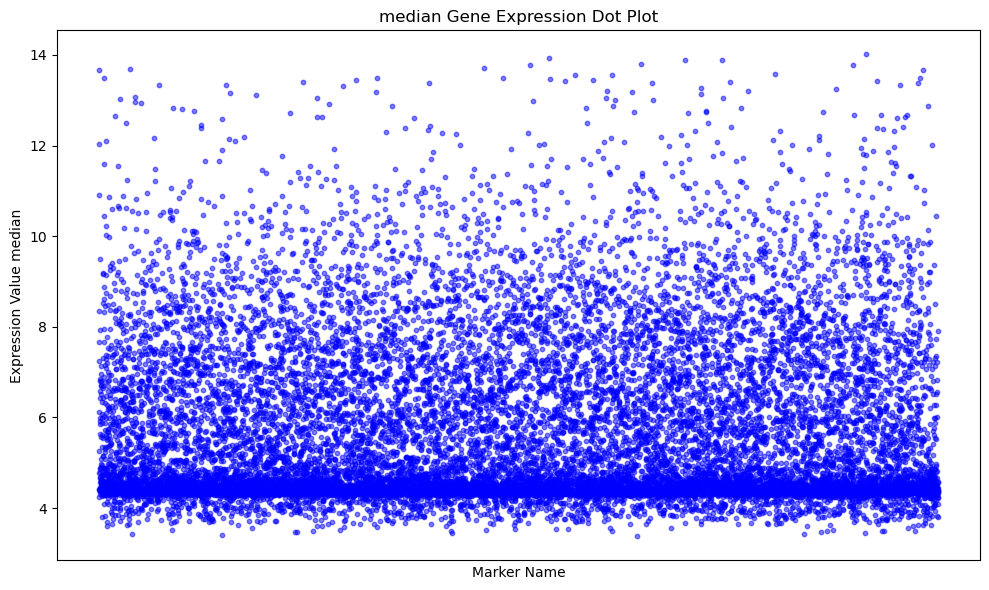

In [10]:
marray_whole_blood_young = marray_whole_blood[marray_whole_blood['age']<20]
manhattanplot(marray_whole_blood_young, save_name='whole_blood/microarray_whole_blood')

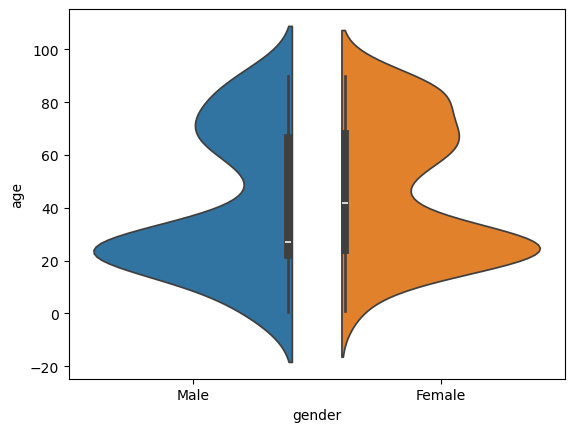

In [11]:
violinplot_overall(marray_whole_blood, x_topic='gender', y_topic='age', hue_split='gender', bin_name='whole_blood/microarray_whole_blood')
# starke abweichung von RNAseq, ComBat für bayes based batch correction -> soll wohl lt. homas nicht weil GAMLSS das bereits berücksichtigt


# ################ RNAseq

In [12]:
#### RNA-Seq Whole Blood and PBMC Data: 
# The RNA-Seq whole blood data was downloaded from Immport (Studies: SDY1092, SDY1172, SDY1381, and SDY1412).
# The files used from Immport were formatted and normalized by the EPIC Consortium. 
#### This apparently made the FKPM transofrmation. -> TPM
# The whole blood datasets were converted into TPM files and harmonized together using the HarmonyRNA algorithm. 
#### 
# More information on the study can be found in this Nature Article published by Amy H. Lee, et al. 
# Some minor additional formatting was done for presenting data on 10k Immunomes.

In [13]:

## Formatted means: background correction, quantile normalization, and log2 normalization
## Normalized: empirical Bayes algorithm for batch correction (2), compensating for possible batch effects

print('RNAseq Whole blood: ')
rna_seq_whole_blood_T = rna_seq_whole_blood.T
rna_seq_whole_blood_T.reset_index(0, inplace=True)

## Hier hab ich quasi 2 headlines: eins ist eben für die ENSGxxxxx nummern und eine f+r den Gene bezeichner -> mapping table 
ensg_numbers = rna_seq_whole_blood_T.iloc[0]
ensg_2_gene_mapping_df = pd.DataFrame([rna_seq_whole_blood_T.iloc[0], rna_seq_whole_blood_T.iloc[1]]).T
ensg_2_gene_mapping_df.columns=ensg_2_gene_mapping_df.iloc[0]
ensg_2_gene_mapping_df = ensg_2_gene_mapping_df.drop(ensg_2_gene_mapping_df.index[0])


rna_seq_whole_blood_T.columns = rna_seq_whole_blood_T.iloc[1]
rna_seq_whole_blood_T = rna_seq_whole_blood_T.drop(rna_seq_whole_blood_T.index[0])
rna_seq_whole_blood_T = rna_seq_whole_blood_T.drop(rna_seq_whole_blood_T.index[0])

### METADATA
rnaseq_whole_blood_metadata = pd.read_csv(ten_k_prefix+'rnaseq_whole_blood_metadata.csv')
print(rnaseq_whole_blood_metadata.shape)

### Bugfix for SDY1381 Subject names
def add_X(row):
    if row['Study']=='SDY1381':
        return 'X' + row['Subject']
    else:
        return row['Subject']
rnaseq_whole_blood_metadata['Subject'] = rnaseq_whole_blood_metadata.apply(add_X, axis=1)

print(rna_seq_whole_blood_T.shape)
rna_seq_whole_blood_T = rna_seq_whole_blood_T.rename(columns={'hgnc': 'Subject'})
rna_seq_whole_blood_T_w_meta = pd.merge(rna_seq_whole_blood_T, rnaseq_whole_blood_metadata, on='Subject', how='inner')

## da wir hier glaub dier selben subjects mit longitudinal data haben: 
unique_subjects = [x.split('_')[0] for x in rna_seq_whole_blood_T_w_meta['Subject'].tolist()]
print(f'Genes: {rna_seq_whole_blood_T_w_meta.shape}')
print(f'Studies: {len(rna_seq_whole_blood_T_w_meta['Study'].unique())}')
print(rna_seq_whole_blood_T_w_meta['Study'].unique())
print(f'Subjects: {len(set(unique_subjects))}')

mapping_platform_geo_id = {'SDY1412': 'GPL16791', 
                           'SDY1092': 'GPL11154', 
                           'SDY1172': 'GPL11154', 
                           'SDY1381': 'GPL11154'}
mapping_platform_description = {'SDY1412': 'Illumina HiSeq 2500 (Homo sapiens)', 'SDY1092': 'Illumina HiSeq 2500 (Homo sapiens)', 
                    'SDY1172': 'Illumina HiSeq 2500 (Homo sapiens)', 'SDY1381': 'Illumina HiSeq 2500 (Homo sapiens)'}
rna_seq_whole_blood_T_w_meta['PLATFORM_GEO_ID'] = rna_seq_whole_blood_T_w_meta['Study'].apply(lambda x: mapping_platform_geo_id.get(x))
rna_seq_whole_blood_T_w_meta['PLATFORM_DESCRIPTION'] = rna_seq_whole_blood_T_w_meta['Study'].apply(lambda x: mapping_platform_description.get(x))


## Rearrange columns: 
cols = rna_seq_whole_blood_T_w_meta.columns.tolist()
cols = cols[-6:] + cols[:-6]
rna_seq_whole_blood_T_w_meta = rna_seq_whole_blood_T_w_meta[cols]
rna_seq_whole_blood_T_w_meta = rna_seq_whole_blood_T_w_meta.drop_duplicates()
#rna_seq_whole_blood_T_w_meta = rna_seq_whole_blood_T_w_meta.dropna()
### maybe 10k uses other datasets besides immport and those are nan ? -> figure out
rna_seq_whole_blood_T_w_meta['Sex'] = rna_seq_whole_blood_T_w_meta['Sex'].apply(lambda x: x.lower() if isinstance(x, str) else x)

rna_seq_whole_blood_T_w_meta.to_csv(f'whole_blood/rna_seq_whole_blood/rnaseq_whole_blood_prepared.csv')
rna_seq_whole_blood_T_w_meta.head()

rna_seq_whole_blood_T_w_meta

#Studies: SDY1092, SDY1172, SDY1412 and -> missing: SDY1381
### that one was tricky, in all_Data we got a leading X infront of all subjects from SDY1381, 
### i will now add a leading X to my metadata for this study and hope it fixes it

RNAseq Whole blood: 
(353, 5)
(353, 9588)
Genes: (353, 9592)
Studies: 4
['SDY1412' 'SDY1092' 'SDY1172' 'SDY1381']
Subjects: 319


,Age,Sex,Study,Expression,PLATFORM_GEO_ID,PLATFORM_DESCRIPTION,Subject,A1BG,AAAS,AACS,...,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM7,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX
0,0.000000,male,SDY1412,44.426690,GPL16791,Illumina HiSeq 2500 (Homo sapiens),P14_D0,44.42669,0.0,122.037397,...,27.200014,5.621336,0.0,0.0,34.816018,19.946677,16.682675,0.0,21.034678,8.160004
1,0.008219,male,SDY1412,40.104895,GPL16791,Illumina HiSeq 2500 (Homo sapiens),P14_D3,40.104895,0.0,27.336806,...,24.554017,0.0,0.0,0.0,21.771229,15.387184,21.443842,0.0,18.98844,0.0
2,0.000000,female,SDY1412,55.732340,GPL16791,Illumina HiSeq 2500 (Homo sapiens),P17_D0,55.73234,0.0,202.885273,...,24.444009,5.051762,0.0,0.0,21.673688,22.651448,21.347768,0.0,18.903367,7.333203
3,0.019178,female,SDY1412,65.247413,GPL16791,Illumina HiSeq 2500 (Homo sapiens),P17_D7,65.247413,0.0,66.43373,...,33.077298,6.350283,10.397716,0.0,30.634882,16.189732,27.564415,0.0,30.076615,6.140933
4,0.000000,male,SDY1412,48.798705,GPL16791,Illumina HiSeq 2500 (Homo sapiens),P21_D0,48.798705,0.0,290.402091,...,29.876758,6.17453,0.0,0.0,26.490726,20.316196,18.324412,0.0,23.104693,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,16.000000,female,SDY1381,2.759483,GPL11154,Illumina HiSeq 2500 (Homo sapiens),X107_L5.LB3,2.759483,1.314039,83.178693,...,1.314039,0.0,0.131404,0.0,1.971059,5.124754,1.051232,0.131404,3.547906,3.285098
349,16.000000,female,SDY1381,91.909349,GPL11154,Illumina HiSeq 2500 (Homo sapiens),X19_L3.LB5,91.909349,1.25731,115.169582,...,22.505846,6.160818,2.640351,0.0,23.637425,18.356724,29.295319,0.125731,23.260232,5.657894
350,18.000000,female,SDY1381,63.454456,GPL11154,Illumina HiSeq 2500 (Homo sapiens),X39_L1.LB10,63.454456,1.24177,63.081925,...,22.227686,8.940745,10.8034,0.0,23.345279,13.535295,30.920077,0.124177,21.606801,8.568214
351,18.000000,female,SDY1381,52.906243,GPL11154,Illumina HiSeq 2500 (Homo sapiens),X96_L5.LB23,52.906243,2.513361,66.981063,...,26.390287,14.828828,2.639029,0.0,25.510611,22.997251,25.133607,0.377004,19.101541,8.671094


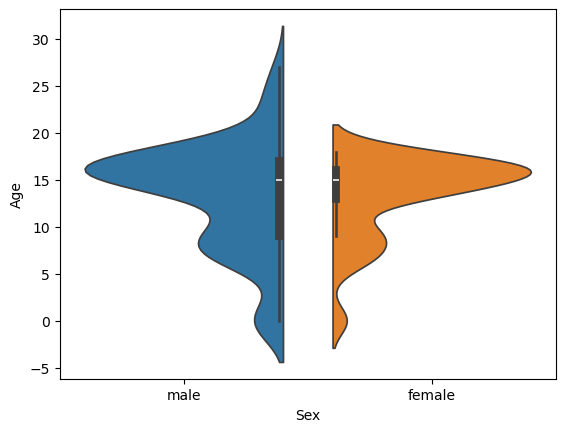

In [14]:
   
violinplot_overall(rna_seq_whole_blood_T_w_meta, x_topic='Sex', y_topic='Age', hue_split='Sex', bin_name='whole_blood/rna_seq_whole_blood')


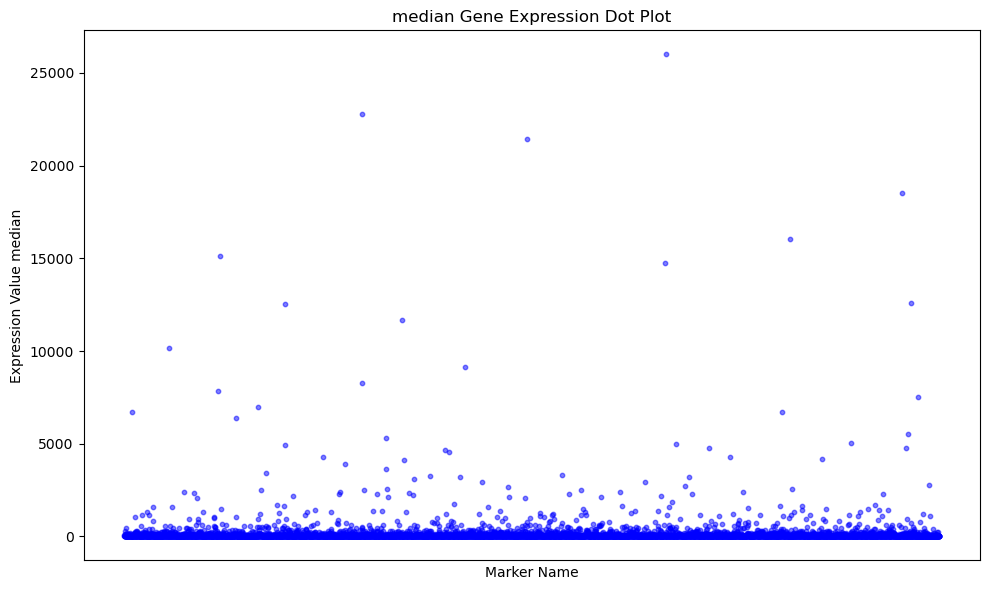

In [15]:
manhattanplot(rna_seq_whole_blood_T_w_meta, start_col=7, save_name='whole_blood/rna_seq_whole_blood')
# Große abweichung von array


# Aus paper. Leider keine info, da des wohl nachgereicht wurde:
#   Additionally, some highly sought data types, such as RNA sequencing (RNA-seq), are not yet available in sufficient volume in ImmPort to merit inclusion in the initial release of the resource

In [16]:
rna_seq_whole_blood_T_wo_meta = rna_seq_whole_blood_T_w_meta.iloc[:,7:]
metadata = rna_seq_whole_blood_T_w_meta.iloc[:,:7]
rna_seq_whole_blood_T_wo_meta = rna_seq_whole_blood_T_wo_meta.astype(float)
rna_seq_whole_blood_T_wo_meta.head()

,A1BG,AAAS,AACS,AAGAB,AAK1,AAMP,AARS2,AASDH,AASDHPPT,AATK,...,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM7,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX
0,44.426690,0.0,122.037397,9.248005,11.786673,5.621336,291.765486,24.480013,14.506674,71.989371,...,27.200014,5.621336,0.000000,0.0,34.816018,19.946677,16.682675,0.0,21.034678,8.160004
1,40.104895,0.0,27.336806,8.348366,6.056658,5.074497,227.042812,22.098615,8.839446,64.986299,...,24.554017,0.000000,0.000000,0.0,21.771229,15.387184,21.443842,0.0,18.988440,0.000000
2,55.732340,0.0,202.885273,8.310963,41.065935,5.051762,254.054731,21.999608,14.829365,64.532183,...,24.444009,5.051762,0.000000,0.0,21.673688,22.651448,21.347768,0.0,18.903367,7.333203
3,65.247413,0.0,66.433730,8.234433,24.005465,3.628733,261.896837,26.378099,8.862483,87.089596,...,33.077298,6.350283,10.397716,0.0,30.634882,16.189732,27.564415,0.0,30.076615,6.140933
4,48.798705,0.0,290.402091,0.000000,21.710444,6.174530,286.816880,26.889083,13.344952,79.073820,...,29.876758,6.174530,0.000000,0.0,26.490726,20.316196,18.324412,0.0,23.104693,0.000000


## Own preprocessing of RNAseq whole blood 
#### was done to "match" manhattan plots

In [17]:
## AXIS 0 is rows (y) and AXIS 1 is cols (x)
### we do this to rteduce technical artifacty that i assume are super high 
### quantile normalization is a technique for making two distributions identical in statistical properties
# I do this using qnorm
import qnorm
rna_seq_whole_blood_T_wo_meta_quant = qnorm.quantile_normalize(rna_seq_whole_blood_T_wo_meta, axis=0)
#### -> you do this if you expect the distributions to be the same. Actually i can not ...

rna_seq_whole_blood_T_wo_meta_quant = rna_seq_whole_blood_T_wo_meta_quant+1 ## I do this bc log2 of 0-1 value is negative
rna_seq_whole_blood_T_wo_meta_log2 = np.log2(rna_seq_whole_blood_T_wo_meta_quant)
rna_seq_whole_blood_T_wo_meta_log2.to_csv('whole_blood/rna_seq_whole_blood/rna_seq_whole_blood_T_wo_meta_preproc.csv')


In [18]:
rna_seq_whole_blood_T_w_meta = rna_seq_whole_blood_T_w_meta.rename(columns={'Age': 'age', 'Sex': 'gender', 'Study':'study_accession', 'Expression': 'data_accession', 
                                             'Subject': 'subject_accession'})
print(rna_seq_whole_blood_T_w_meta['gender'].unique())
## apply the preproc to the with meta df
rna_seq_whole_blood_T_w_meta_log2 = metadata.join(rna_seq_whole_blood_T_wo_meta_log2)
#rna_seq_whole_blood_T_w_meta_log2 = rna_seq_whole_blood_T_wo_meta_log2.combine_first(rna_seq_whole_blood_T_w_meta)
rna_seq_whole_blood_T_w_meta_log2.to_csv(f'whole_blood/rna_seq_whole_blood/rna_seq_whole_blood_T_w_meta_preproc.csv')

['male' 'female']


In [19]:
rna_seq_whole_blood_T_w_meta_log2.shape

(353, 9594)

In [20]:
rna_seq_whole_blood_T_w_meta_log2.describe()

,Age,Expression,A1BG,AAAS,AACS,AAGAB,AAK1,AAMP,AARS2,AASDH,...,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM7,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,...,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,13.456362,56.072877,5.728803,1.705296,6.993478,3.149876,4.093551,2.538877,8.023678,4.581747,...,4.807061,2.684613,1.669523,0.289307,4.825984,4.306546,4.432834,0.855416,4.676103,2.440499
std,4.927598,21.794855,0.503801,0.968338,0.975786,0.658455,1.604248,0.403222,0.427769,0.374258,...,0.542649,0.877805,1.254286,0.472312,0.452105,0.367781,0.528979,1.156101,0.679363,0.816849
min,0.000000,0.134218,3.578556,0.018972,3.138426,0.535458,0.001196,1.137379,5.752851,3.415539,...,1.956926,0.032758,0.043487,0.000002,2.175896,2.175896,2.175896,0.019301,1.796378,0.019301
25%,10.000000,42.233097,5.431612,1.074393,6.304009,2.783578,3.248131,2.319777,7.796300,4.370517,...,4.551666,2.300221,0.677000,0.038912,4.599726,4.089859,4.133984,0.256696,4.284057,1.974224
50%,15.000000,53.127880,5.764838,1.458424,7.000233,3.180148,4.254117,2.538749,8.051475,4.585684,...,4.836111,2.832850,1.491945,0.054374,4.862877,4.318226,4.516260,0.522110,4.709449,2.492439
75%,17.000000,68.661816,6.076405,2.160148,7.648064,3.590414,5.161745,2.768952,8.334315,4.824390,...,5.154379,3.285789,2.283432,0.140980,5.118031,4.540845,4.793929,0.912329,5.099156,2.993981
max,27.000000,167.534029,7.247416,5.133433,11.045132,4.626113,7.473996,4.663916,9.007143,5.754616,...,5.975367,4.473907,5.929886,2.175896,6.181842,5.622151,5.567067,6.827317,6.352737,5.133433


In [21]:
description = rna_seq_whole_blood_T_w_meta_log2.describe().T
negative_mins = description[description['min'] < 0]
print(negative_mins)

Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


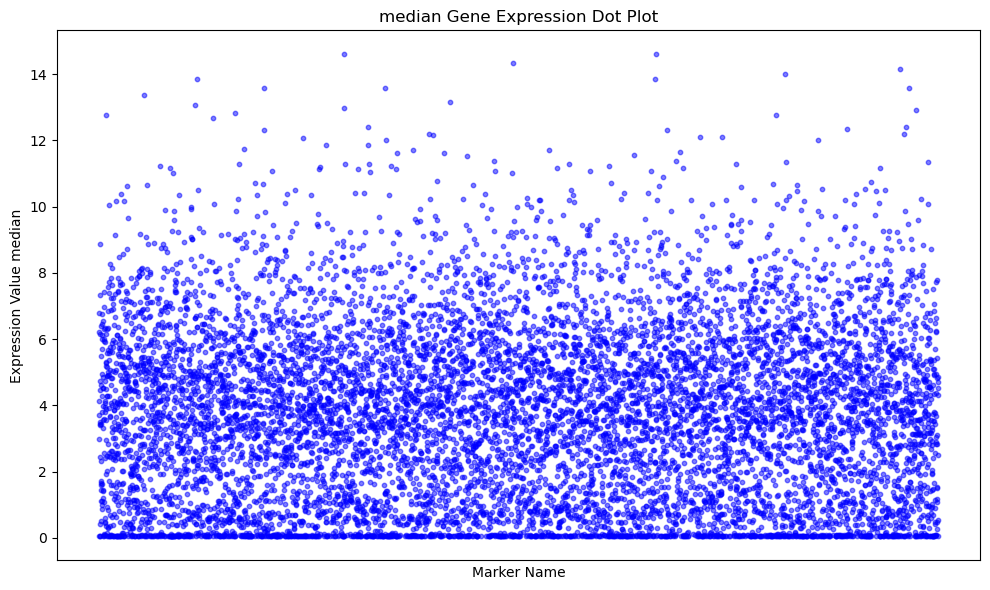

In [22]:
manhattanplot(rna_seq_whole_blood_T_wo_meta_log2)

# ################# MERGE whole blood

In [23]:
### Merge the data
## Step1: Common cols: 
## Step2: Common metadata: (adapt rna_seq_whole_blood_T_w_meta to marray)
rna_seq_whole_blood_T_w_meta_log2['METHOD']='rnaseq'
marray_whole_blood['METHOD']='array'
common_columns = rna_seq_whole_blood_T_w_meta_log2.columns.intersection(marray_whole_blood.columns)

combi_df_whole_blood = pd.concat([marray_whole_blood, rna_seq_whole_blood_T_w_meta_log2], ignore_index=True)
combi_df_whole_blood['gender'] = combi_df_whole_blood['gender'].str.lower()
combi_df_whole_blood['TYPE']='whole_blood'
### Combi df of all data CONTAINING Nan and possible duplicates
print(combi_df_whole_blood.shape)
#combi_df_whole_blood.to_csv(f'whole_blood/whole_blood_combi_all.csv')

(760, 18701)


/tmp/ipykernel_9979/350474410.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combi_df_whole_blood['TYPE']='whole_blood'


In [24]:
no_meta_cols = list(set(common_columns) - set(METADATA_COLS))
print(len(no_meta_cols))
new_order_cols = METADATA_COLS + no_meta_cols
print(len(new_order_cols))

9319
9328


In [25]:
combi_df_whole_blood_common_columns = combi_df_whole_blood[new_order_cols]
combi_df_whole_blood_common_columns.to_csv(f'whole_blood/whole_blood_combi_common_columns.csv')

In [26]:
combi_df_whole_blood_common_columns.head()

,age,study_accession,gender,subject_accession,METHOD,TYPE,PLATFORM_DESCRIPTION,PLATFORM_GEO_ID,data_accession,ZNF780B,...,NMRAL1,P2RX1,AIDA,SESN3,THBS1,CD247,FXN,BTRC,PPM1D,ANKRA2
0,63.9,SDY111,male,SUB116437,array,whole_blood,Illumina HumanHT-12 V4.0 expression beadchip,GPL10558,GSM2300358,6.643427,...,7.571484,7.051346,8.142350,6.995102,6.658873,10.739610,6.536331,6.514704,7.091634,7.141515
1,63.9,SDY111,male,SUB116437,array,whole_blood,Illumina HumanHT-12 V4.0 expression beadchip,GPL10558,GSM2300366,6.643427,...,7.571484,7.051346,8.142350,6.995102,6.658873,10.739610,6.536331,6.514704,7.091634,7.141515
2,64.2,SDY111,female,SUB116438,array,whole_blood,Illumina HumanHT-12 V4.0 expression beadchip,GPL10558,GSM2300371,6.579592,...,7.662610,6.903911,8.172963,8.251970,6.486278,9.911002,6.592442,6.564838,6.738873,7.120171
3,64.2,SDY111,female,SUB116438,array,whole_blood,Illumina HumanHT-12 V4.0 expression beadchip,GPL10558,GSM2300363,6.579592,...,7.662610,6.903911,8.172963,8.251970,6.486278,9.911002,6.592442,6.564838,6.738873,7.120171
4,68.9,SDY111,female,SUB116439,array,whole_blood,Illumina HumanHT-12 V4.0 expression beadchip,GPL10558,GSM2300374,6.687882,...,7.340000,7.126756,8.428654,7.615707,6.517377,10.176184,6.459261,6.531540,6.924896,7.155366


In [27]:
combi_df_whole_blood.head()

,PLATFORM_GEO_ID,PLATFORM_DESCRIPTION,data_accession,subject_accession,age,gender,race,study_accession,EEF1A1,GAPDH,...,ZNF738,ZNF783,ZNF799,ZNF814,ZNF852,ZNF879,ZNF890P,ZNF90,ZSCAN12,TYPE
0,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300358,SUB116437,63.9,male,White,SDY111,12.900495,10.160145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_blood
1,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300366,SUB116437,63.9,male,White,SDY111,12.900495,10.160145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_blood
2,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300371,SUB116438,64.2,female,White,SDY111,12.525918,10.023569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_blood
3,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300363,SUB116438,64.2,female,White,SDY111,12.525918,10.023569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_blood
4,GPL10558,Illumina HumanHT-12 V4.0 expression beadchip,GSM2300374,SUB116439,68.9,female,White,SDY111,12.936886,10.050780,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_blood


In [28]:

### Remove possible duplicated subjects and entries with Nan 
combi_df_whole_blood_reduced = combi_df_whole_blood.drop_duplicates()
combi_df_whole_blood_reduced = combi_df_whole_blood_reduced.drop_duplicates(subset=['subject_accession'], keep='first')
print(combi_df_whole_blood_reduced.shape)

## drop entries that dont fullfill those min metadata
essential_columns = ['age', 'gender', 'PLATFORM_GEO_ID']
combi_df_whole_blood_reduced = combi_df_whole_blood_reduced.dropna(subset=essential_columns, axis=0, how='any')
print(combi_df_whole_blood_reduced.shape)
### Here i wanted to fix an error that i made by renaming the cols (sex, gender... )

# TODO 
## impute mean value 
## calc percentage of nan per gene. 
## drop biomarkers for values with Nan
# this reduces the genes to about /2 
combi_df_whole_blood_reduced = combi_df_whole_blood_reduced.dropna(axis=1, how='any') 
print(combi_df_whole_blood_reduced.shape)
combi_df_whole_blood_reduced.to_csv(f'whole_blood/whole_blood_combi_reduced.csv')

(277, 18701)
(276, 18701)
(276, 18428)


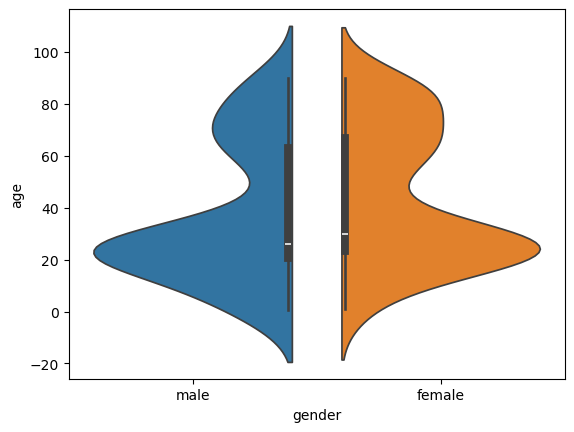

In [29]:
violinplot_overall(combi_df_whole_blood_reduced,  x_topic='gender', y_topic='age', hue_split='gender', bin_name='whole_blood')

In [30]:
combi_df_whole_blood_reduced.columns

Index(['PLATFORM_GEO_ID', 'PLATFORM_DESCRIPTION', 'data_accession',
       'subject_accession', 'age', 'gender', 'race', 'study_accession',
       'EEF1A1', 'GAPDH',
       ...
       'SNHG8', 'NA.221', 'PSORS1C3', 'PISRT1', 'NA.222', 'NA.223',
       'KRTAP22-2', 'KRTAP21-3', 'METHOD', 'TYPE'],
      dtype='object', length=18428)

In [31]:
manhattanplot(combi_df_whole_blood_reduced, start_col=9, save_name='whole_blood/manhattan_plot.csv')

TypeError: Cannot convert ['array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array' 'array'
 'array' 'array' 'array' 'array' 'array' 'array'] to numeric

### individual plots

In [ ]:

### So we got our tables now: 
##### Next steps
# TODO: 
## - find paper that uses microarray and RNAseq, both...
#### decided to wait for answer of 10k --- 
## - find nonhealthy samples (what are  the samples we currently got ?) -> they are healthy as 10k lists only healthy subjects! 
#### "Subject-level immunology data from >10,000 healthy normal human subjects"



In [ ]:
description = combi_df_whole_blood_reduced.describe().T
negative_mins = description[description['min'] < 0]
print(negative_mins)
print(combi_df_whole_blood_reduced.shape)
combi_df_whole_blood_reduced.describe()
